# 1) Convert .txt matrix to .h5ad matrix

## approach 1:
### very memory intensive

In [4]:
import scanpy as sc
import numpy as np

**read in the dge matrix as produced by my pipeline**  
The dge matrix is a .txt file. The dimensions are in the wrong orientation, which is why the andata object has to be transposed.

In [ ]:
path = "/Users/manuel/Desktop/dge_m_10.txt"
k = sc.read_text(path)

**transpose the count matrix**  
We transpose the count matrix and save it in a numpay array which is then saved as a txt file.

In [ ]:
np_array_t = k.X.transpose()

In [ ]:
np.savetxt("/Users/manuel/Desktop/dge_m_10_t.txt", np_array_t)

**load dge matrix again - this time with correct dimensions**  
We load only the matrix (no cell labels or gene names) this time with the correct dimensions as a andata object. Then we assign the correct column and row names that we still know from the previous andata object k (with the wrong dimensions).

In [ ]:
k_new = sc.read_text("/Users/manuel/Desktop/dge_m_10_t.txt")

In [ ]:
k_new.obs = k.var
k_new.var = k.obs

**verify everything worked out fine**

In [ ]:
k_new

In [ ]:
k_new.obs

In [ ]:
k_new.var

**safe scnapy (AnnData) object**  
We can first convert the matrix into a sparse format and then use the AnnData function `.write()` to save our scanpy (AnnData) object.

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
k_new.X = csr_matrix(k_new.X)

In [ ]:
k_new.write("/Users/manuel/Desktop/dge_m_10_t_out.h5ad", compression='gzip', force_dense=True)

In [ ]:
path = "/Users/manuel/Desktop/dge_m_10_t_out.h5ad"
k_new_2 = sc.read(path)

## approach 2:
### ----> works better for large files

In [1]:
import anndata
import scanpy as sc
import numpy as np

In [13]:
path = "/Users/manuel/Desktop/test.txt"
k = sc.read_text(path)

In [14]:
n_obs = len(k.var)
n_var = len(k.obs)
k_t = anndata.AnnData(X=None, shape=(n_obs, n_var))

In [15]:
k_t.X = k.X.transpose()

In [16]:
k_t.obs = k.var
k_t.var = k.obs

In [18]:
k_t.obs

""
AGCGTATAGAAACCAT
CATGACAGTAGGACAC
GTGTTAGAGTAGGTG


In [7]:
k_t.write("/Users/manuel/Desktop/dge.h5ad", compression='gzip')

In [ ]:
import anndata
import scanpy as sc
import numpy as np

In [ ]:
path = "/Users/manuel/Desktop/dge.txt"
k = sc.read_text(path)

In [ ]:
k_t.X = k.X.transpose()
k_t.obs = k.var
k_t.var = k.obs

# 2) Convert .mat to .h5ad matrix

In [1]:
from scipy import io as spio
import anndata as ad
import pandas as pd

In [ ]:
matrx = spio.loadmat("/Users/manuel/Downloads/GSM3017265_frozen_preserved_cells_nuclei_200_UBCs.mat")

In [ ]:
matrx

In [ ]:
len(matrx['barcodes'][0])

In [ ]:
# have a look at different elements in matrx objec
matrx
matrx['DGE']
matrx['genes']

In [ ]:
# create anndata object with matrix in matrx object
k_t = ad.AnnData(matrx['DGE'])
# assign genes element of matrx as pandas DataFrame to var
k_t.var = pd.DataFrame(matrx['genes'])
# assign barcode element of matrx as pandas DataFrame to obs
k_t.obs = pd.DataFrame(matrx['barcodes'][0])

In [ ]:
# we now want to get a dataframe that has only rownames (corresponding to gene names)
# of type str

k = k_t.var

# extract gene names
gene_names = []
for i in range(len(k)):
    gene_names.append(str(k[0][i]))

# make dictionary that maps gene names (in int16) of colum to value of rownames
my_dic = {}
old_row_names = k.index.values
for i in range(len(k)):
    my_dic[old_row_names[i]] = gene_names[i]

# change the rownames
k = k.rename(index=my_dic)

# remove the column that for some weird reason contained the gene names
k = k.drop([0], axis=1)

In [ ]:
# we now want to get a dataframe that has only rownames (corresponding to barcodes)
# of type str

uu = k_t.obs

gene_names = []
for i in range(len(uu)):
    gene_names.append(str(uu[0][i]))

my_dic = {}
old_row_names = uu.index.values
for i in range(len(uu)):
    my_dic[old_row_names[i]] = gene_names[i]
    
uu = uu.rename(index=my_dic)
uu = uu.drop([0], axis=1)

In [ ]:
# assign the row and col data back in the correct format (DataFrame with all entries
# of type str)
k_t.var = k
k_t.obs = uu

In [ ]:
output_file = "/Volumes/win_mac/dge_matrix_original/GSM3017261_150000_CNS_nuclei.h5ad"
k_t.write(output_file, compression='gzip')

# 3) Convert .mat to .h5ad matrix with .tsv

In [5]:
# matrx = spio.loadmat("/Users/manuel/Desktop/dge_original/matrix.mtx")
dge = sc.read_mtx("/Users/manuel/Desktop/dge_original/matrix.mtx")

In [6]:
dge.ob

AnnData object with n_obs × n_vars = 32835 × 6464 

In [8]:
import csv

In [9]:
file = csv.reader("/Users/manuel/Desktop/dge_original/features.tsv")

In [18]:
dge_2 = sc.read_10x_mtx("/Users/manuel/Desktop/dge_original/")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [31]:
dge_2.

In [32]:
dge_2.write("/Users/manuel/Desktop/dge_original/dge_orig.h5ad", compression='gzip')

... storing 'feature_types' as categorical


## analysis

In [24]:
sc.pp.calculate_qc_metrics(dge_2, inplace=True)

Trying to set attribute `.obs` of view, making a copy.


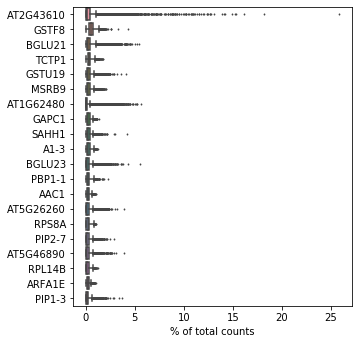

In [25]:
sc.pl.highest_expr_genes(dge_2, n_top=20, )

In [27]:
sc.pp.normalize_total(dge_2, target_sum=1e4)
sc.pp.log1p(dge_2)
sc.pp.highly_variable_genes(dge_2, min_mean=0.0125, max_mean=3, min_disp=0.5)
sub_hvg = dge_2[:, dge_2.var.highly_variable]
sub_hvg

View of AnnData object with n_obs × n_vars = 6464 × 4120 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

/Users/manuel/anaconda3/envs/scanpy_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'feature_types' as categorical


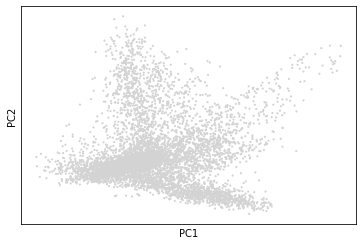

In [28]:
sc.pp.scale(sub_hvg, max_value=10)
sc.tl.pca(sub_hvg, svd_solver='arpack', n_comps=100)
sc.pl.pca(sub_hvg)

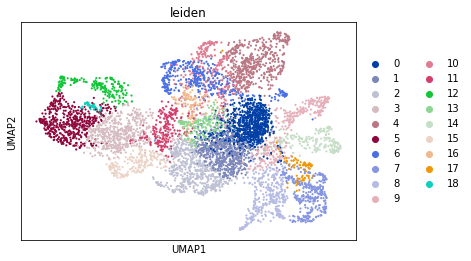

In [29]:
sc.pp.neighbors(sub_hvg, n_neighbors=30, n_pcs=50)
sc.tl.umap(sub_hvg)
sc.tl.leiden(sub_hvg)
sc.pl.umap(sub_hvg, color='leiden')

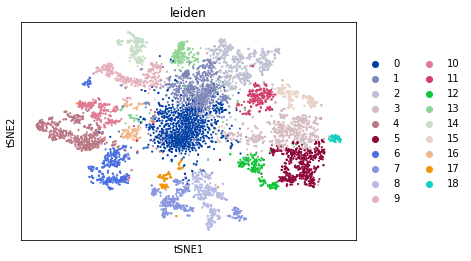

In [30]:
sc.tl.tsne(sub_hvg)
sc.pl.tsne(sub_hvg, color='leiden')